## MLPerf Training/HPC results visualization

## Choose benchmark

In [ ]:
from collections import namedtuple
MLPerfBenchmark = namedtuple('MLPerfBenchmark',['round','name'])

In [ ]:
# Choose benchmark to visualize

# benchmark = MLPerfBenchmark(round='training_results_v0.7', name='resnet') 
benchmark = MLPerfBenchmark(round='hpc_results_v0.7', name='cosmoflow') 
# benchmark = MLPerfBenchmark(round='hpc_results_v0.7', name='deepcam')

In [ ]:
# paths of results repos
import json
with open('mlperf_results_paths.json', 'r') as results_paths_f:
    mlperf_results_dirs = json.load(results_paths_f)

## Parse results

In [4]:
import glob
import re
import os
import subprocess
import math
import numpy as np
from pprint import pprint
from IPython.display import display

In [5]:
benchmark_results_dir = mlperf_results_dirs[benchmark.round]
mlperf_results_dirs[benchmark.round]

'../hpc_results_v0.7/'

In [6]:
benchmark_submissions = glob.glob( os.path.join(benchmark_results_dir, '*/results/*/' + benchmark.name) )
benchmark_submissions

['../hpc_results_v0.7/Fujitsu/results/abci_2048xV100_tensorflow_open/cosmoflow',
 '../hpc_results_v0.7/Fujitsu/results/fugaku_16384xA64FX_tensorflow_open/cosmoflow',
 '../hpc_results_v0.7/Fujitsu/results/fugaku_8192xA64FX_tensorflow_closed/cosmoflow',
 '../hpc_results_v0.7/Fujitsu/results/abci_512xV100_tensorflow_closed/cosmoflow',
 '../hpc_results_v0.7/RIKEN/results/fugaku_512xA64FX_tensorflow_closed/cosmoflow',
 '../hpc_results_v0.7/CSCS/results/daint_gpu_n256_tf2.2.0/cosmoflow',
 '../hpc_results_v0.7/CSCS/results/daint_gpu_n128_tf2.2.0/cosmoflow',
 '../hpc_results_v0.7/NCSA/results/halv100_n16_tf1.15.0/cosmoflow',
 '../hpc_results_v0.7/LBNL/results/coriknl_n512_tf1.15.2/cosmoflow',
 '../hpc_results_v0.7/LBNL/results/coriknl_n1024_tf1.15.2/cosmoflow',
 '../hpc_results_v0.7/LBNL/results/corigpu_n64_tf1.15.0/cosmoflow',
 '../hpc_results_v0.7/TACC/results/frontera_rtx_n16_tf1.15.2_lbs1/cosmoflow']

In [7]:
# %%bash
# ls $(pwd)/${benchmark_results_dir}/*/systems/

In [8]:
# # Check and move Alibaba results for consistency
# %%bash

# ls $(pwd)/${benchmark_results_dir}/Alibaba/results/n1_A100/resnet 
# #git mv Alibaba/results/n1_A100/resnet/{200711025203744603517_5.log,result_5.txt}

In [9]:
mlperf_opts = {
    'training_results_v0.7': {},
    'hpc_results_v0.7': {},
}

In [10]:
# MLPerf Training ResNet hyperparameters
mlperf_opts['training_results_v0.7']['resnet'] = {
    
    # global_batch_size

    # opt_name can be lars or sgd for closed

    'opt_opts_names' : dict(
        lars=\
        ['lars_opt_base_learning_rate',
         'lars_opt_end_learning_rate',
         'lars_opt_learning_rate_decay_poly_power',
         'lars_epsilon',
         'lars_opt_learning_rate_warmup_epochs',
         'lars_opt_momentum',
         'lars_opt_weight_decay',
         'lars_opt_learning_rate_decay_steps'],
        sgd=\
        ['sgd_opt_base_learning_rate',
         'sgd_opt_end_learning_rate',
         'sgd_opt_learning_rate_decay_poly_power',
         'sgd_opt_learning_rate_decay_steps',
         'sgd_opt_weight_decay',
         'sgd_opt_momentum',
         'model_bn_span',
         'opt_learning_rate_warmup_epochs']
    ),
    'runs_to_submit' : 5,
    'eval_target_key': 'eval_accuracy',
} 

In [11]:
# MLPerf HPC Cosmoflow hyperparameters
mlperf_opts['hpc_results_v0.7']['cosmoflow'] = {

    # global_batch_size

    # opt_name must be SGD for closed

    'opt_opts_names' : dict(
        SGD=\
        ['sgd_opt_momentum',
         'opt_base_learning_rate',
         'opt_learning_rate_warmup_epochs',
         'opt_learning_rate_warmup_factor',
         'opt_learning_rate_decay_boundary_epochs',
         'opt_learning_rate_decay_factor']
    ),
    'runs_to_submit' : 10,
    'eval_target_key': 'eval_error',
}

In [12]:
# MLPerf HPC DeepCAM hyperparameters

mlperf_opts['hpc_results_v0.7']['deepcam'] = {

    # global_batch_size

    # opt_name must be AdamW or LAMB  for closed

    'opt_opts_names' : dict(
        AdamW=\
        ['opt_epsilon',
         'opt_base_learning_rate',
         'opt_learning_rate_warmup_steps',
         'opt_learning_rate_warmup_factor',
         'opt_learning_rate_decay_steps',
         'opt_learning_rate_decay_factor',
         'opt_weight_decay',
        ],
        LAMB=\
        ['opt_epsilon',
         'opt_base_learning_rate',
         'opt_learning_rate_warmup_steps',
         'opt_learning_rate_warmup_factor',
         'opt_weight_decay',
        ]
#         'validation_frequency', fixed to 100
#         'loss_weight_pow'       fixed to -0.125
    ),
    
    'runs_to_submit' : 5,
    'eval_target_key': 'eval_accuracy',
}

In [13]:
# Optimizer/hyperparameters
global_batch_size_pattern =  re.compile(r'[\s\S]*:::MLLOG([\s\S]+?"key":[\s]*?"{}"[\s\S]+?)$[\s\S]*'.format('global_batch_size'), re.M) # [\s\S]*^ at the beginning not possible due to NVIDIA submission
opt_name_pattern =           re.compile(r'[\s\S]*:::MLLOG([\s\S]+?"key":[\s]*?"{}"[\s\S]+?)$[\s\S]*'.format('opt_name'), re.M)

opt_patterns = { 
    opt_name:  { k: re.compile(r'[\s\S]*:::MLLOG([\s\S]+?"key":[\s]*?"{}"[\s\S]+?)$[\s\S]*'.format(k), re.M) 
              for k in mlperf_opts[benchmark.round][benchmark.name]['opt_opts_names'][opt_name] }
    for opt_name in mlperf_opts[benchmark.round][benchmark.name]['opt_opts_names']
}

# Epochs to convergence
run_start_pattern =        re.compile(r'[\s\S]*^:::MLLOG([\s\S]+?"key":[\s]*?"{}"[\s\S]+?)$'.format('run_start'), re.M)
run_stop_pattern =         re.compile(r'[\s\S]*^:::MLLOG([\s\S]+?"key":[\s]*?"{}"[\s\S]+?)$'.format('run_stop'), re.M)

last_eval_target_pattern = re.compile(r'[\s\S]*^:::MLLOG([\s\S]+?"key":[\s]*?"{}"[\s\S]+?)$[\s\S]+?"key":[\s]*?"{}"[\s\S]+'.format(mlperf_opts[benchmark.round][benchmark.name]['eval_target_key'], 'run_stop'), re.M)

In [14]:
# # Testing
# print("asdf \n fdasqwer")
# result = re.compile('[\s\S]+^ (fdasqwer) $[\s\S]+', re.M).match("asdf \n fdasqwer \n 1234")
# print(result.group(0))

In [15]:
# %%bash
# grep sgd_opt_momentum $(pwd)/${benchmark_results_dir}/Fujitsu/results/fugaku_8192xA64FX_tensorflow_closed/cosmoflow/*

In [16]:
submissions_stats = dict()
for submission in benchmark_submissions: 

    print(submission, flush=True)
    submitter = submission.split('/')[-4]
    system_name  = submission.split('/')[-2]
    with open(os.path.join('/'.join(submission.split('/')[:-3]), 'systems', system_name + '.json'), 'r') as system_desc_file:
        system_desc = json.load(system_desc_file)
        system_desc['division'] = system_desc['division'].lower()
        if not system_desc['division'] in ['open', 'closed']:
            print(f'Erroneous division {system_desc["division"]} in system description of {submitter}!')
    submission_results = glob.glob(submission + '/result*')
    results = []
    for result in submission_results:

        global_batch_size_content = subprocess.run(['/bin/grep', 'global_batch_size', result], capture_output=True).stdout.decode('utf-8')
        global_batch_size = json.loads(global_batch_size_pattern.search(global_batch_size_content).group(1))['value']

        opt_name_content = subprocess.run(['/bin/grep', 'opt_name', result], capture_output=True).stdout.decode('utf-8')
        opt_name = json.loads(opt_name_pattern.search(opt_name_content).group(1))['value']
        
        if benchmark.name == 'cosmoflow':
            if opt_name == 'SGDWD' and submission.endswith('Fujitsu/results/fugaku_8192xA64FX_tensorflow_closed/cosmoflow'):
                opt_name = 'SGD'
        
        opt_opts = {}
        if system_desc['division'] == 'closed':
            for opt_opt, opt_opt_pattern in opt_patterns[opt_name].items():
                if opt_opt == 'sgd_opt_momentum': # no one is using it - forgotten in the reference implementation?
                    continue 
                if benchmark.name == 'deepcam' and opt_opt == 'opt_weight_decay' and 'corigpu_n64_pt1.6.0' in submission:
                    opt_opts[opt_opt] = 0.01
                    continue                 
                opt_opt_content = subprocess.run(['/bin/grep', opt_opt, result], capture_output=True).stdout.decode('utf-8')
                opt_opts[opt_opt] = json.loads(opt_opt_pattern.search(opt_opt_content).group(1))['value']
#         print(global_batch_size_content, flush=True)            


        run_stop_content = subprocess.run(['/bin/grep', '-C', '8', 'run_stop', result], capture_output=True).stdout.decode('utf-8')
#         print(run_stop_content, flush=True)
        
        run_stop_match = run_stop_pattern.search(run_stop_content)
        if run_stop_match is None:
            print(f"Skipping {result} (run_stop not found)", flush=True)
            continue
#         print(json.loads(run_stop_match.group(1)), flush=True)
        run_stop = json.loads(run_stop_match.group(1))
        if 'status' in run_stop['metadata'] and run_stop['metadata']['status'] != 'success':
            print(f"Skipping {result} (run_stop status was {json.loads(run_stop_match.group(1))['metadata']['status']} != success)", flush=True)
            continue
        elif not 'status' in run_stop['metadata']:
            print(f"Warning: {result} has no status field: run_stop['metadata'] = {json.loads(run_stop_match.group(1))['metadata']}", flush=True)
            
#         print(run_stop_content, flush=True)
        run_start_content = subprocess.run(['/bin/grep', 'run_start', result], capture_output=True).stdout.decode('utf-8')
        run_start_match = run_start_pattern.search(run_start_content)
        run_start = json.loads(run_start_match.group(1))
        
        run_time = (run_stop['time_ms']-run_start['time_ms'])/1000. if 'time_ms' in run_stop else run_stop['time_s']-run_start['time_s']

        last_eval_target_match = json.loads(last_eval_target_pattern.search(run_stop_content).group(1))
        run_stop_epoch = last_eval_target_match['metadata']['epoch_num']
        
        results.append( dict(
            global_batch_size=global_batch_size, 
            opt_name=opt_name,
            opt_opts=opt_opts,
            run_stop_epoch=run_stop_epoch,
            run_time=run_time,
            run_epoch_throughput=run_stop_epoch/run_time,
            division=system_desc['division'],
            system=system_desc,
        ) )
    
    # Reduce shared features across runs
    submission_stats_results = dict()
    for k in results[0].keys():
        if not k.startswith('run'):
            for r in results[1:]:
                assert results[0][k] == r[k]
            submission_stats_results[k] = results[0][k]
    
    # run-specific features as a sequence
    submission_stats_results['runs'] = []
    for r in results:
        submission_stats_results['runs'].append({ k: r[k] for k in results[0].keys() if k.startswith('run')})
    submissions_stats[submission] = submission_stats_results
    
submissions_ids = {k.split('/')[-4]: 0 for k in submissions_stats.keys()}

for k in submissions_stats.keys():
    submitter = k.split('/')[-4]
    system = k.split('/')[-2]
    submissions_ids[submitter] += 1
    submissions_stats[k]['submission_short_label'] = submitter + f'-{submissions_ids[submitter]}'
    submissions_stats[k]['submission_label'] =       submitter + f'-{submissions_ids[submitter]}/' + system


../hpc_results_v0.7/Fujitsu/results/abci_2048xV100_tensorflow_open/cosmoflow
../hpc_results_v0.7/Fujitsu/results/fugaku_16384xA64FX_tensorflow_open/cosmoflow
../hpc_results_v0.7/Fujitsu/results/fugaku_8192xA64FX_tensorflow_closed/cosmoflow
../hpc_results_v0.7/Fujitsu/results/abci_512xV100_tensorflow_closed/cosmoflow
../hpc_results_v0.7/RIKEN/results/fugaku_512xA64FX_tensorflow_closed/cosmoflow
../hpc_results_v0.7/CSCS/results/daint_gpu_n256_tf2.2.0/cosmoflow
Skipping ../hpc_results_v0.7/CSCS/results/daint_gpu_n256_tf2.2.0/cosmoflow/result_4.txt (run_stop not found)
../hpc_results_v0.7/CSCS/results/daint_gpu_n128_tf2.2.0/cosmoflow
../hpc_results_v0.7/NCSA/results/halv100_n16_tf1.15.0/cosmoflow
../hpc_results_v0.7/LBNL/results/coriknl_n512_tf1.15.2/cosmoflow
../hpc_results_v0.7/LBNL/results/coriknl_n1024_tf1.15.2/cosmoflow
../hpc_results_v0.7/LBNL/results/corigpu_n64_tf1.15.0/cosmoflow
../hpc_results_v0.7/TACC/results/frontera_rtx_n16_tf1.15.2_lbs1/cosmoflow


## Visualize results

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
%matplotlib inline

In [19]:
plt.rcParams.update({'font.size': 14})

### Plotting functions

In [20]:
# kernel density estimator for plot

from sklearn.neighbors import KernelDensity
from scipy.stats import norm


def kde_estimate(run_stop_epochs):
    # instantiate and fit the KDE model    
    kde = KernelDensity(bandwidth=0.5*np.std(run_stop_epochs), kernel='gaussian')
    kde.fit(run_stop_epochs[:,None])

    # score_samples returns the log of the probability density
    epochs = np.linspace(np.min(run_stop_epochs)-2.5*np.std(run_stop_epochs), np.max(run_stop_epochs)+2.5*np.std(run_stop_epochs), 100)
    return epochs, np.exp(kde.score_samples(epochs[:,None]))
#     mean, std = norm.fit(run_stop_epochs)
#     return epochs, norm.pdf(epochs, mean, std)

In [21]:
# TODO: Make filtering interactive with widgets

def plot_all_submissions(x_key, y_key, x_label=None, y_label=None, y_transform=None, title=None, sharey=False, axis_scale='semilogx', filter_submissions=lambda s: True, color_label=None):
    
    if type(x_key) is str:
        assert not x_key.startswith('run_')
    if type(y_key) is str:
        assert y_key.startswith('run_')

    fig, (ax0, ax1) = plt.subplots(ncols=2, sharey=sharey, #sharex=True, 
                                   figsize=(36, 12))

    cmap = plt.cm.get_cmap('prism')
    colors = cmap(np.arange(0,cmap.N))
    if color_label is None:
        colors = colors[::len(colors)//len(submissions_stats),:]*0.7
    else:
        color_label_range = np.unique([color_label(submission_stat) for submission_stat in submissions_stats.values() if filter_submissions(submission_stat)])
        colors = colors[::len(colors)//len(color_label_range),:]*0.7
#         np.random.shuffle(colors)
        colors = dict(zip(color_label_range, colors))
    
    # Plot all submissions
    for i, (k, submission_stat) in enumerate(submissions_stats.items()):
        
#         submission_stat = submissions_stats[k]
        
        if not filter_submissions(submission_stat):
            continue

        color = colors[i if color_label is None else color_label(submission_stat)]
            
        x_values = submission_stat[x_key] if type(x_key) is str else x_key(submission_stat)

        submission_stat_runs = sorted(submission_stat['runs'], key=lambda run: run['run_time'])
        submission_stat_runs = submission_stat_runs[1:mlperf_opts[benchmark.round][benchmark.name]['runs_to_submit']-1] # olympic scoring rules

        y_values = np.array([run[y_key] if type(y_key) is str else y_key({'run': run, 'system': submission_stat['system']}) for run in submission_stat_runs])

        if y_transform is not None:
            y_values = np.array([y_transform(val) for val in y_values])
#         print(y_values, flush=True)

        if submission_stat['division'] == 'closed':                
            y_values_unique = np.unique(y_values)
            y_values_frequency = np.array([np.sum(e == np.array(y_values)) for e in y_values_unique])
            ax0.scatter([x_values]*len(y_values_unique),
                        y_values_unique,
                        s=10*y_values_frequency,
                        color=color,
                        label=submission_stat['submission_label'] + (f' ({color_label(submission_stat)})' if color_label is not None else ''),
                        alpha=1.)
            ax0.annotate(submission_stat['submission_short_label'],
                        xy=(x_values, np.mean(y_values)),
                        xytext=(-10, 0),
                        textcoords="offset points", # arrowprops={'width': 1, 'headwidth': 1, 'headlength': 1, 'shrink':0.05, 'color':color },
                        ha='right', va='center',  # rotation=90,
                        color=color,
                        alpha=1.)        
            if len(y_values_unique) != 1:
                epochs, probs = kde_estimate(y_values)
                ax0.plot(   float(x_values)*2**(np.std(y_values)*probs),
                            epochs,
                            color=color,
                            alpha=0.5)
                ax0.fill_betweenx(
                            epochs,
                            [float(x_values)]*len(probs),
                            float(x_values)*2**(np.std(y_values)*probs),
                            color=color,
                            alpha=0.1)
        elif submission_stat['division'] == 'open':
            y_values_unique = np.unique(y_values)
            y_values_frequency = np.array([np.sum(e == np.array(y_values)) for e in y_values_unique])
            ax1.scatter([x_values]*len(y_values_unique),
                        y_values_unique,
                        s=10*y_values_frequency,
                        color=color,
                        label=submission_stat['submission_label'] + (f' ({color_label(submission_stat)})' if color_label is not None else ''),
                        alpha=1.)
            ax1.annotate(submission_stat['submission_short_label'],
                        xy=(x_values, np.mean(y_values)),
                        xytext=(-10, 0),
                        textcoords="offset points", # arrowprops={'width': 1, 'headwidth': 1, 'headlength': 1, 'shrink':0.05, 'color':color },
                        ha='right', va='center',  # rotation=90,
                        color=color,
                        alpha=1.)        
            if len(y_values_unique) != 1:
                epochs, probs = kde_estimate(y_values)
                ax1.plot(   float(x_values)*2**(np.std(y_values)*probs),
                            epochs,
                            color=color,
                            alpha=0.5)
                ax1.fill_betweenx(
                            epochs,
                            [float(x_values)]*len(probs),
                            float(x_values)*2**(np.std(y_values)*probs),
                            color=color,
                            alpha=0.1)
        else:
            raise ValueError(f"Invalid division {submission_stat['division']}.")

    ax0.legend(bbox_to_anchor=(-.55, 1), loc='upper left', frameon=False, fontsize='small')
    ax1.legend(bbox_to_anchor=(1.55, 1), loc='upper right', frameon=False, fontsize='small')

    ax0.grid(True, which='major', alpha=0.3)
    ax1.grid(True, which='major', alpha=0.3)

    if axis_scale == 'linear':
        ax0.plot()
        ax1.plot()
    elif axis_scale == 'semilogx':
        ax0.semilogx()
        ax1.semilogx()
    elif axis_scale == 'loglog':
        ax0.loglog()
        ax1.loglog()
    else:
        raise ValueError(f'axis_scale should be in [semilogx, loglog, plot], not {axis_scale}')
        

    x_range = dict()

    for division in ['closed', 'open']:
        x_range[division] = [submission_stat[x_key] if type(x_key) is str else x_key(submission_stat) for submission_stat in submissions_stats.values() if submission_stat['division'] == division and filter_submissions(submission_stat)]

    if len(x_range['closed']) > 0:
        ax0.set_xlim(left=np.min(x_range['closed'])//2 if axis_scale != 'linear' else 0., right=np.max(x_range['closed'])*2)
    if len(x_range['open']) > 0:
        ax1.set_xlim(left=np.min(x_range['open'])//2 if axis_scale != 'linear' else 0.,   right=np.max(x_range['open'])*2)


    ax0.xaxis.set_major_locator(plt.LogLocator(base=2.))
    ax1.xaxis.set_major_locator(plt.LogLocator(base=2.))

    #     plt.FuncFormatter(lambda t: "{}".format(t))
    ax0.xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
    ax1.xaxis.set_major_formatter(plt.ScalarFormatter())

    ax0.set_xlabel(x_label if x_label is not None else x_key)
    ax1.set_xlabel(x_label if x_label is not None else x_key)
    ax0.set_ylabel(y_label)
    ax1.set_ylabel(y_label)

    fig.suptitle(benchmark.round + '/' + benchmark.name + ' - '+ (title if title is not None else f'{x_label} vs. {y_label}'))
    fig.tight_layout()

In [22]:
#%matplotlib notebook

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def coord_transform(values, transform):
    if transform is None:
        return values
    else:
        return transform(values) if not hasattr(values,'__len__') else np.array([transform(val) for val in values])

def plot_all_submissions_3d(x_key, y_key, z_key, 
                            x_label=None, x_transform=None, 
                            y_label=None, y_transform=None, 
                            z_label=None, z_transform=None, 
                            title=None, sharez=False, 
                            axis_scale='semilogx', 
                            filter_submissions=lambda s: True, 
                            color_label=None):
    
    for key in [x_key, y_key]:
        if type(key) is str:
            assert not key.startswith('run_')
    if type(z_key) is str:
        assert z_key.startswith('run_')

    fig, (ax0, ax1) = plt.subplots(ncols=2, #sharez=sharez, #sharex=True, 
                                   figsize=(27, 9), subplot_kw={'projection':'3d'})

    cmap = plt.cm.get_cmap('prism')
    colors = cmap(np.arange(0,cmap.N))
    if color_label is None:
        colors = colors[::len(colors)//len(submissions_stats),:]*0.7
    else:
        color_label_range = np.unique([color_label(submission_stat) for submission_stat in submissions_stats.values() if filter_submissions(submission_stat)])
        colors = colors[::len(colors)//len(color_label_range),:]*0.7
#         np.random.shuffle(colors)
        colors = dict(zip(color_label_range, colors))
    
    # Plot all submissions
    ax0_text = []
    ax1_text = []
    for i, (k, submission_stat) in enumerate(submissions_stats.items()):
        
        if not filter_submissions(submission_stat):
            continue

        color = colors[i if color_label is None else color_label(submission_stat)]
            
        x_values = submission_stat[x_key] if type(x_key) is str else x_key(submission_stat)
        y_values = submission_stat[y_key] if type(y_key) is str else y_key(submission_stat)

        submission_stat_runs = sorted(submission_stat['runs'], key=lambda run: run['run_time'])
        submission_stat_runs = submission_stat_runs[1:mlperf_opts[benchmark.round][benchmark.name]['runs_to_submit']-1] # olympic scoring rules

        z_values = np.array([run[z_key] if type(z_key) is str else z_key({'run': run, 'system': submission_stat['system']}) for run in submission_stat_runs])
        z_values = coord_transform(z_values, z_transform)
        
#         print(z_values, flush=True)

        if submission_stat['division'] == 'closed':                
            z_values_unique = np.unique(z_values)
            z_values_frequency = np.array([np.sum(e == np.array(z_values)) for e in z_values_unique])
            ax0.scatter(coord_transform([x_values]*len(z_values_unique), x_transform),
                        coord_transform([y_values]*len(z_values_unique), y_transform),
                        z_values_unique,
                        s=10*z_values_frequency,
                        color=color,
                        label=submission_stat['submission_label'] + (f' ({color_label(submission_stat)})' if color_label is not None else ''),
                        alpha=1.)

            ax0_text.append(dict(x=coord_transform(x_values, x_transform), 
                     y=coord_transform(y_values, y_transform), 
                     z=np.mean(z_values),
                     s=submission_stat['submission_short_label'], #textcoords="offset points", # arrowprops={'width': 1, 'headwidth': 1, 'headlength': 1, 'shrink':0.05, 'color':color }, ha='right', va='center',  # rotation=90,
                     color=color,
                     fontsize='small',
                     alpha=1.))
            
            if len(z_values_unique) != 1:
                epochs, probs = kde_estimate(z_values)
                ax0.plot(   coord_transform(float(x_values)*2**(np.std(z_values)*probs), x_transform),
                            coord_transform(float(y_values)*2**(np.std(z_values)*probs), y_transform),
                            epochs,
                            color=color,
                            alpha=0.5)
                
                verts = list(zip(coord_transform([float(x_values)]*len(probs), x_transform),
                                 coord_transform([float(y_values)]*len(probs), y_transform),
                                 epochs))
                verts.reverse()
                verts += list(zip(coord_transform(float(x_values)*2**(np.std(z_values)*probs), x_transform),
                                  coord_transform(float(y_values)*2**(np.std(z_values)*probs), y_transform), 
                                  epochs))
                ax0.add_collection3d(Poly3DCollection([verts], color=color, alpha=0.1))
                
        elif submission_stat['division'] == 'open':
            z_values_unique = np.unique(z_values)
            z_values_frequency = np.array([np.sum(e == np.array(z_values)) for e in z_values_unique])
            ax1.scatter(coord_transform([x_values]*len(z_values_unique), x_transform),
                        coord_transform([y_values]*len(z_values_unique), y_transform),
                        z_values_unique,
                        s=10*z_values_frequency,
                        color=color,
                        label=submission_stat['submission_label'] + (f' ({color_label(submission_stat)})' if color_label is not None else ''),
                        alpha=1.)
            
            ax1_text.append(dict(x=coord_transform(x_values, x_transform), 
                     y=coord_transform(y_values, y_transform), 
                     z=np.mean(z_values),
                     s=submission_stat['submission_short_label'], #textcoords="offset points", # arrowprops={'width': 1, 'headwidth': 1, 'headlength': 1, 'shrink':0.05, 'color':color }, ha='right', va='center',  # rotation=90,
                     color=color,
                     fontsize='small',
                     alpha=1.))
            
            if len(z_values_unique) != 1:
                epochs, probs = kde_estimate(z_values)
                ax1.plot(   coord_transform(float(x_values)*2**(np.std(z_values)*probs), x_transform),
                            coord_transform(float(y_values)*2**(np.std(z_values)*probs), y_transform),
                            epochs,
                            color=color,
                            alpha=0.5)
                
                verts = list(zip(coord_transform([float(x_values)]*len(probs), x_transform),
                                 coord_transform([float(y_values)]*len(probs), y_transform),
                                 epochs))
                verts.reverse()
                verts += list(zip(coord_transform(float(x_values)*2**(np.std(z_values)*probs), x_transform),
                                  coord_transform(float(y_values)*2**(np.std(z_values)*probs), y_transform), 
                                  epochs))
                ax1.add_collection3d(Poly3DCollection([verts], color=color, alpha=0.1))
        else:
            raise ValueError(f"Invalid division {submission_stat['division']}.")

    ax0.legend(bbox_to_anchor=(-.45, 1), loc='upper left', frameon=False, fontsize='medium')
    ax1.legend(bbox_to_anchor=(1.45, 1), loc='upper right', frameon=False, fontsize='medium')

    ax0.grid(True, which='major', alpha=0.3)
    ax1.grid(True, which='major', alpha=0.3)

#     # setting axis scale other than linear non-functional in 3d, must be done with coord_transforms
#     if axis_scale == 'linear':
#         pass    
#         ax0.set_xscale('linear')
#         ax0.set_yscale('linear')
#         ax0.set_zscale('linear')
#         ax1.set_xscale('linear')
#         ax1.set_yscale('linear')
#         ax1.set_zscale('linear')
#     elif axis_scale == 'semilogx':
#         ax0.set_xscale('log')
#         ax0.set_yscale('log')
#         ax0.set_zscale('linear')
#         ax1.set_xscale('log')
#         ax1.set_yscale('log')
#         ax1.set_zscale('linear')
#     elif axis_scale == 'loglog':
#         ax0.set_xscale('log')
#         ax0.set_yscale('log')
#         ax0.set_zscale('log')
#         ax1.set_xscale('log')
#         ax1.set_yscale('log')
#         ax1.set_zscale('log')
#     else:
#         raise ValueError(f'axis_scale should be in [semilogx, loglog, plot], not {axis_scale}')
    
    x_range = dict()
    y_range = dict()

    for division in ['closed', 'open']:
        x_range[division] = [submission_stat[x_key] if type(x_key) is str else x_key(submission_stat) for submission_stat in submissions_stats.values() if submission_stat['division'] == division and filter_submissions(submission_stat)]
        y_range[division] = [submission_stat[y_key] if type(y_key) is str else y_key(submission_stat) for submission_stat in submissions_stats.values() if submission_stat['division'] == division and filter_submissions(submission_stat)]

    if len(x_range['closed']) > 0:
        ax0.set_xlim(left=coord_transform(np.min(x_range['closed'])/2. if axis_scale != 'linear' else 0., x_transform), right=coord_transform(np.max(x_range['closed'])*2., x_transform))
        ax0.set_ylim(bottom=coord_transform(np.min(y_range['closed'])/2. if axis_scale != 'linear' else 0., y_transform), top=coord_transform(np.max(y_range['closed'])*2., y_transform))
        for text in ax0_text:
            text['x'] -= 0.09*(ax0.get_xlim()[1]-ax0.get_xlim()[0])
            text['y'] -= 0.09*(ax0.get_ylim()[1]-ax0.get_ylim()[0])
            text['z'] *= 1.02
            ax0.text(**text)
    if len(x_range['open']) > 0:
        ax1.set_xlim(left=coord_transform(np.min(x_range['open'])/2. if axis_scale != 'linear' else 0., x_transform),   right=coord_transform(np.max(x_range['open'])*2., x_transform))
        ax1.set_ylim(bottom=coord_transform(np.min(y_range['open'])/2. if axis_scale != 'linear' else 0., y_transform),   top=coord_transform(np.max(y_range['open'])*2., y_transform))
        for text in ax1_text:
            text['x'] -= 0.08*(ax1.get_xlim()[1]-ax1.get_xlim()[0])
            text['y'] -= 0.08*(ax1.get_ylim()[1]-ax1.get_ylim()[0])
            text['z'] *= 1.02
            ax1.text(**text)

    ax0.xaxis.set_major_locator(plt.AutoLocator())
    ax1.xaxis.set_major_locator(plt.AutoLocator())
    ax0.yaxis.set_major_locator(plt.AutoLocator())
    ax1.yaxis.set_major_locator(plt.AutoLocator())

    #     plt.FuncFormatter(lambda t: "{}".format(t))
    ax0.xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
    ax1.xaxis.set_major_formatter(plt.ScalarFormatter())
    ax0.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
    ax1.yaxis.set_major_formatter(plt.ScalarFormatter())

    ax0.set_xlabel(x_label if x_label is not None else x_key)
    ax1.set_xlabel(x_label if x_label is not None else x_key)
    ax0.set_ylabel(y_label if y_label is not None else y_key)
    ax1.set_ylabel(y_label if y_label is not None else y_key)
    ax0.set_zlabel(z_label)
    ax1.set_zlabel(z_label)

    fig.suptitle(benchmark.round + '/' + benchmark.name + ' - '+ (title if title is not None else f'({x_label}, {y_label}) vs. {z_label}'))
    fig.tight_layout()

### Label definitions/helpers

In [23]:
if benchmark.round == 'hpc_results_v0.7':
    accelerator_short_names = [
            'A64FX',
            'V100',
            'P100',
            'Quadro RTX 5000',
            'Intel Xeon Phi']
elif benchmark.round == 'training_results_v0.7':
    accelerator_short_names = [
        'Intel(R) Xeon(R)', #' Platinum 8380H',
        'TPU v3',
        'TPU',
#         'A100-SXM4-40GB',
        'A100',
#         'V100-SXM2-32GB',
#         'V100-SXM3-32GB',
#         'V100-SXM2-16GB',
        'V100',
        'Ascend910']
    
def accelerator_name(system):
    return system['accelerator_model_name'] if int(system['accelerators_per_node']) > 0 else system['host_processor_model_name'] 

def accelerator_short_label(submission_stat):
    name = accelerator_name(submission_stat['system'])
    for short_name in accelerator_short_names:
        if short_name in name:
            return short_name

def accelerator_number(system):
    number_of_nodes = int(system['number_of_nodes'])
    accelerators_per_node = int(system['accelerators_per_node'] if int(system['accelerators_per_node']) > 0 else system['host_processors_per_node'])
    return number_of_nodes*accelerators_per_node

if benchmark.round == 'hpc_results_v0.7':
    # Estimating peak performance (TBC: check numbers - Tensor Core performance too high as a reference)
    tflops = {
        'A64FX': 6.8,
        'V100': 112.,
        'P100': 9.3,
        'Quadro RTX 5000': 89.2,
        'Intel Xeon Phi': 3.,
    }

    def get_pflops(system):
        for tfl_key, tfl_val in tflops.items():
            if tfl_key in accelerator_name(system):
                return tfl_val*accelerator_number(system)/1000.

    display({ f'{accelerator_number(v["system"])}x{accelerator_name(v["system"])}': 
                 get_pflops(v['system']) for v in submissions_stats.values() })

{'2048xNVIDIA Tesla V100': 229.376,
 '16384xFUJITSU Processor A64FX': 111.4112,
 '8192xFUJITSU Processor A64FX': 55.7056,
 '512xNVIDIA Tesla V100': 57.344,
 '512xFUJITSU Processor A64FX': 3.4816,
 '256xNVIDIA P100-PCIE-16GB': 2.3808000000000002,
 '128xNVIDIA P100-PCIE-16GB': 1.1904000000000001,
 '64xNVIDIA Tesla V100': 7.168,
 '512xIntel Xeon Phi Processor 7250': 1.536,
 '1024xIntel Xeon Phi Processor 7250': 3.072,
 '64xNVIDIA V100': 7.168,
 '64xNVIDIA Quadro RTX 5000': 5.7088}

### 3D visualization (interactive data exploration in Jupyter notebook)

In [24]:
%%script echo Remove this line for visualization in Jupyter notebook (not working in Jupyter lab)
%matplotlib notebook

# Some choices for x-/y-/z-axes
x_label = 'log(batch size)'
x_key = 'global_batch_size'
x_transform = np.log2

# y_label = 'log(# accelerators)'
# y_key = lambda submission_stat: accelerator_number(submission_stat['system'])
# y_transform = np.log2

y_label = 'log(batch size/# accelerators)'
y_key = lambda submission_stat: float(submission_stat['global_batch_size'])/accelerator_number(submission_stat['system'])
y_transform = np.log2

# z_label = '# epochs to solution'
# z_key = 'run_stop_epoch'
# z_transform = None

# z_label = 'epoch throughput [1/min]'
# z_key = 'run_epoch_throughput'
# z_transform = lambda t: t/60.

z_label = 'epoch throughput per accelerator [1/min]'
z_key = lambda submission_stat: submission_stat['run']['run_stop_epoch']/(submission_stat['run']['run_time']*accelerator_number(submission_stat['system']))
z_transform = lambda t: t*60.


plot_all_submissions_3d(x_key=x_key, x_label=x_label, x_transform=x_transform, 
                        y_key=y_key, y_label=y_label, y_transform=y_transform, 
                        z_key=z_key, z_label=z_label, z_transform=z_transform, 
                        sharez=True, axis_scale='semilogx', color_label=accelerator_short_label)

Remove this line for visualization in Jupyter notebook (not working in Jupyter lab)


### 2d visualizations

In [25]:
# Plot parameters

# x-axis

x_label = 'batch size'
x_key = 'global_batch_size'

x_label = '# accelerators'
x_key = lambda submission_stat: accelerator_number(submission_stat['system'])

# y-axis

y_label = '# epochs to solution'
y_key = 'run_stop_epoch'
y_transform = None

y_label = 'time to solution [min]'
y_key = 'run_time'
y_transform = lambda t: t/60.
    
y_label = 'epoch throughput [1/min]'
y_key = 'run_epoch_throughput'
y_transform = lambda t: t/60.
    
def get_accelerator_hours(run_system_stats):
    return run_system_stats['run']['run_time']/3600*accelerator_number(run_system_stats['system'])

y_label = 'accelerator hours'
y_key = get_accelerator_hours
y_transform = None
    
def get_pflopsdays(run_system_stats):
    return run_system_stats['run']['run_time']/3600./24.*get_pflops(run_system_stats['system'])

y_label = 'PF/s-days'
y_key = get_pflopsdays
y_transform = None

In [26]:
# Checking for correlations of individual hyperparameters on number of epochs to converge is possible (not very helpful when everyone roughly uses the same - hence "if False")

if benchmark.name == 'cosmoflow' and False:
    x_key = lambda run_system_stats: float(run_system_stats['opt_opts']['opt_learning_rate_decay_boundary_epochs'][1])
    x_label = 'opt_learning_rate_decay_boundary_epochs[1]'
    filter_submissions = lambda submission_stat: submission_stat['division'] == 'closed'

    y_label = '# epochs to solution'
    y_key = 'run_stop_epoch'
    y_transform = None

    plot_all_submissions(x_key=x_key, x_label=x_label, y_key=y_key, y_label=y_label, y_transform=y_transform, sharey=True, filter_submissions=filter_submissions)

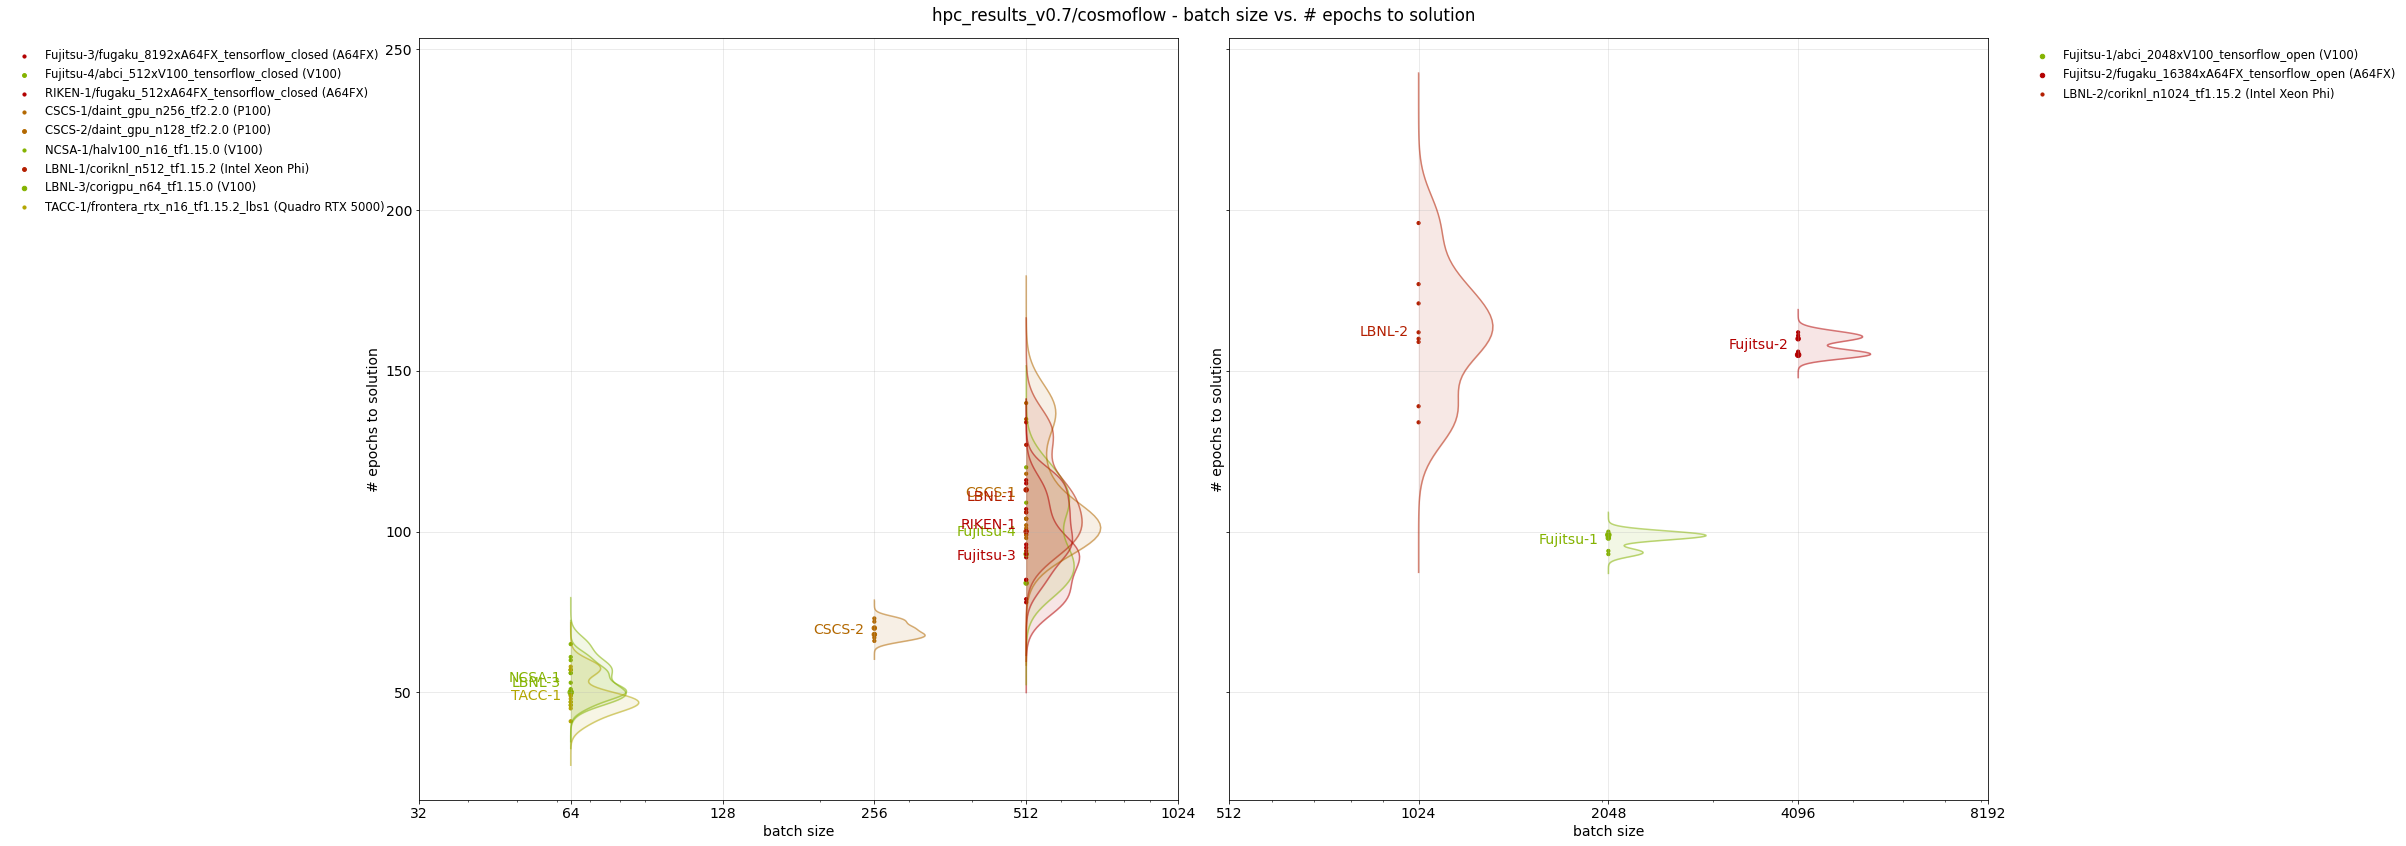

In [27]:
x_label = 'batch size'
x_key = 'global_batch_size'

# x_label = '# accelerators'
# x_key = lambda submission_stat: accelerator_number(submission_stat['system'])

y_label = '# epochs to solution'
y_key = 'run_stop_epoch'
y_transform = None

plot_all_submissions(x_key=x_key, x_label=x_label, y_key=y_key, y_label=y_label, y_transform=y_transform, sharey=True, axis_scale='semilogx', color_label=accelerator_short_label)

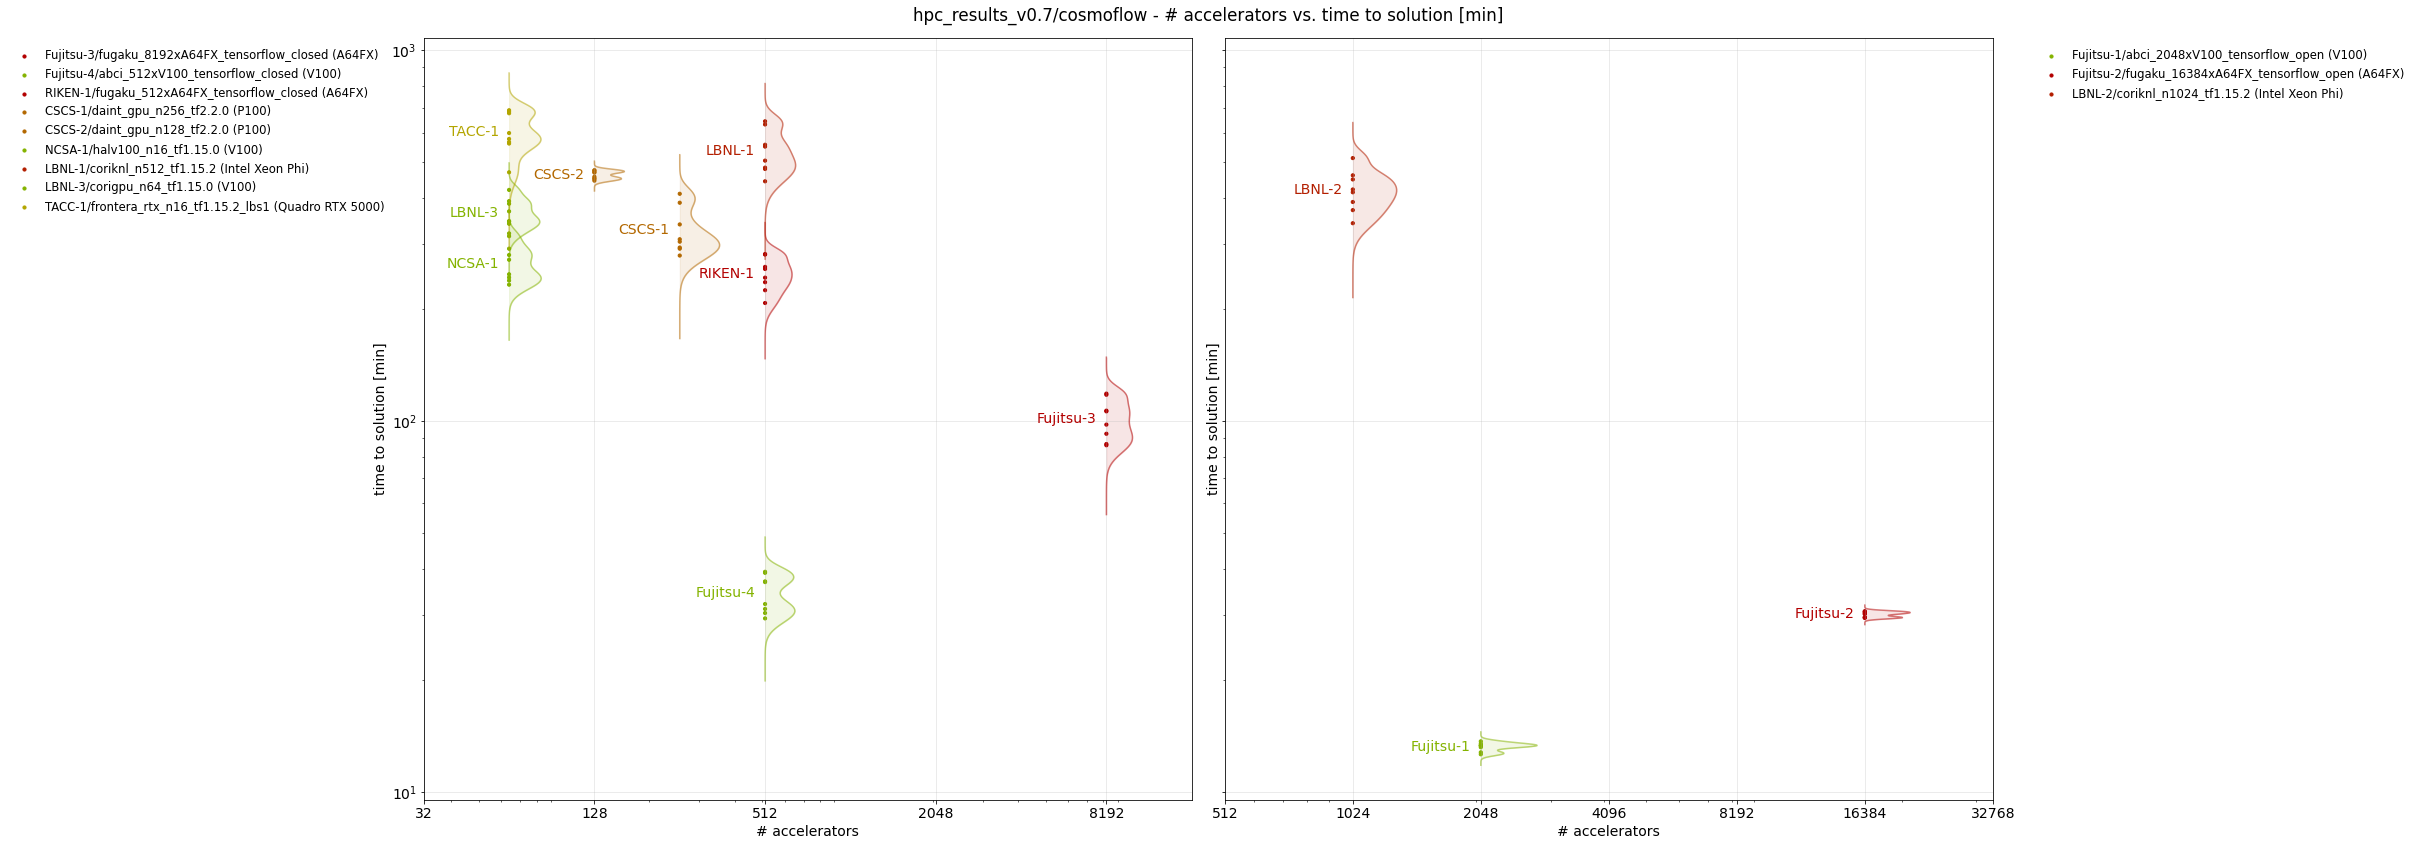

In [28]:
# x_label = 'batch size'
# x_key = 'global_batch_size'

x_label = '# accelerators'
x_key = lambda submission_stat: accelerator_number(submission_stat['system'])

y_label = 'time to solution [min]'
y_key = 'run_time'
y_transform = lambda t: t/60.
    
plot_all_submissions(x_key=x_key, x_label=x_label, y_key=y_key, y_label=y_label, y_transform=y_transform, sharey=True, axis_scale='loglog', color_label=accelerator_short_label)

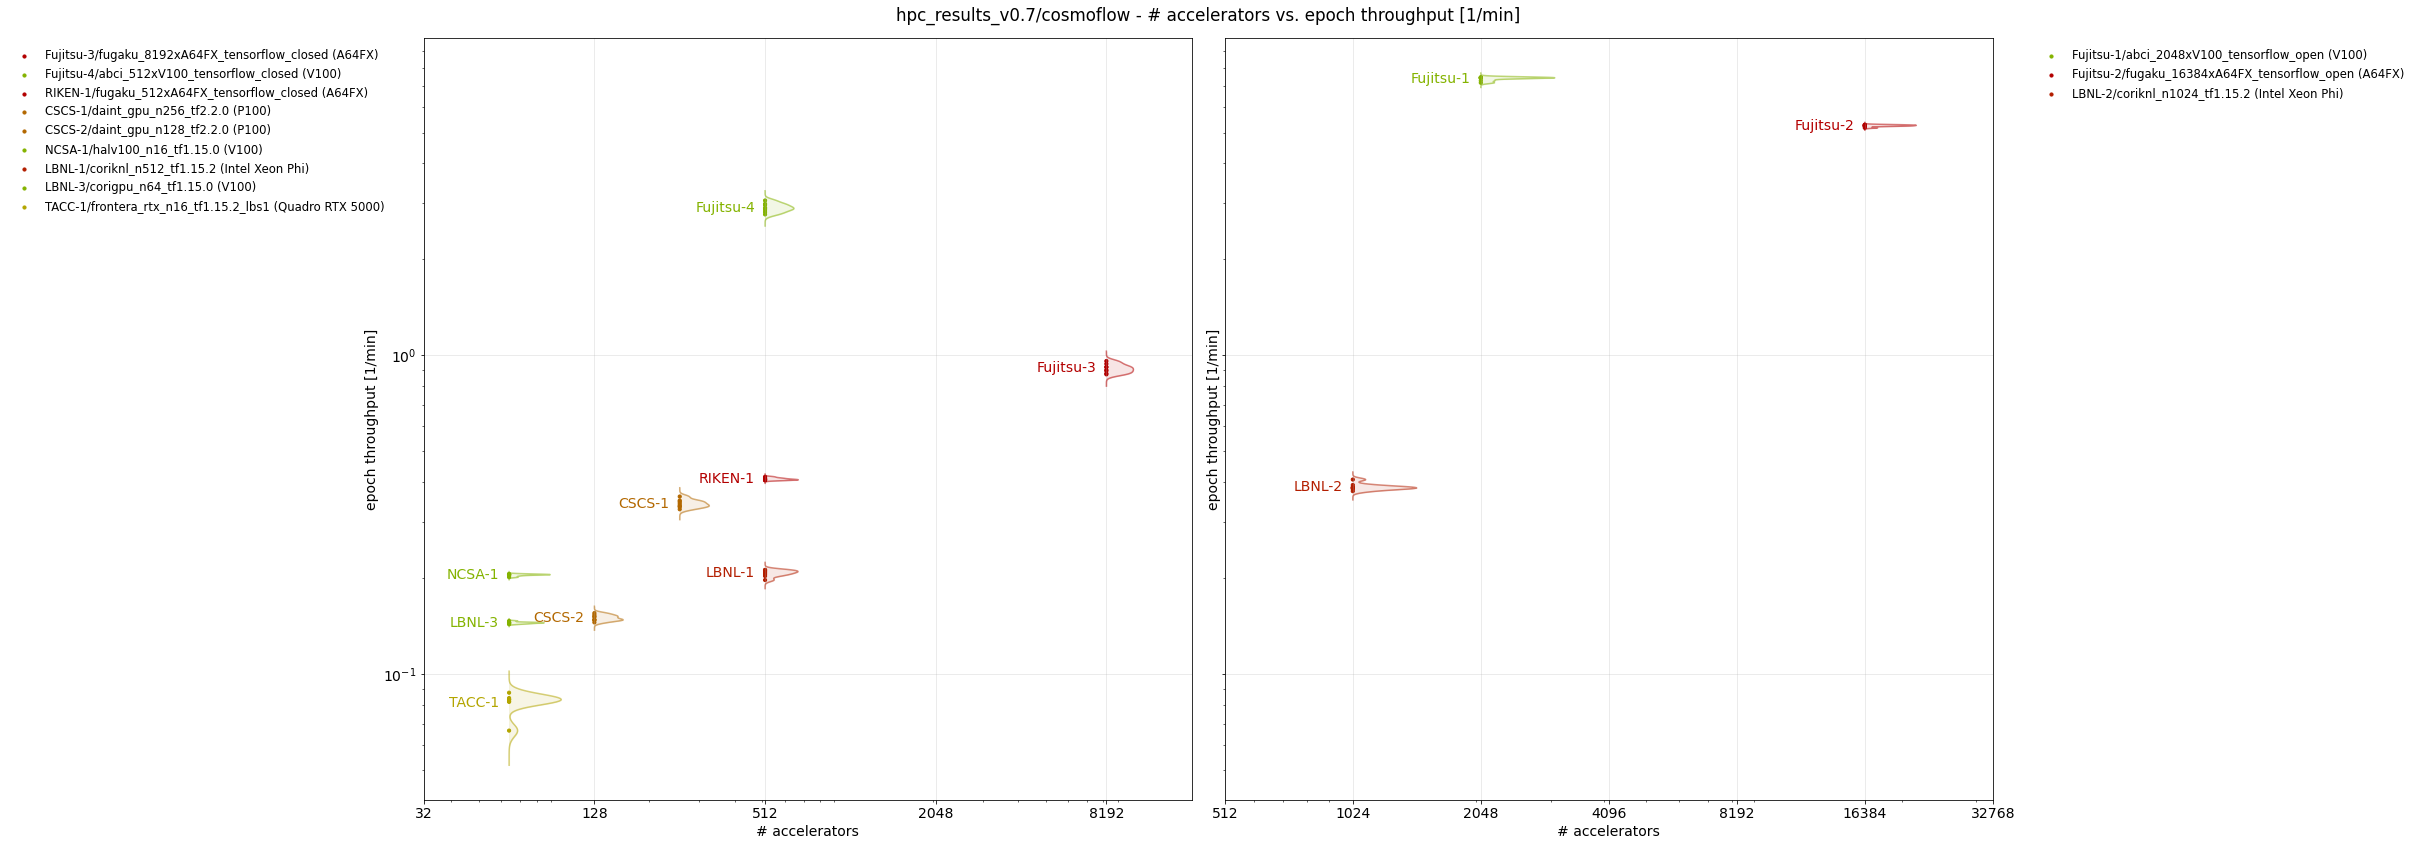

In [29]:
# x_label = 'batch size'
# x_key = 'global_batch_size'

x_label = '# accelerators'
x_key = lambda submission_stat: accelerator_number(submission_stat['system'])

y_label = 'epoch throughput [1/min]'
y_key = 'run_epoch_throughput'
y_transform = lambda t: t*60.
    
plot_all_submissions(x_key=x_key, x_label=x_label, y_key=y_key, y_label=y_label, y_transform=y_transform, sharey=True, axis_scale='loglog', color_label=accelerator_short_label)

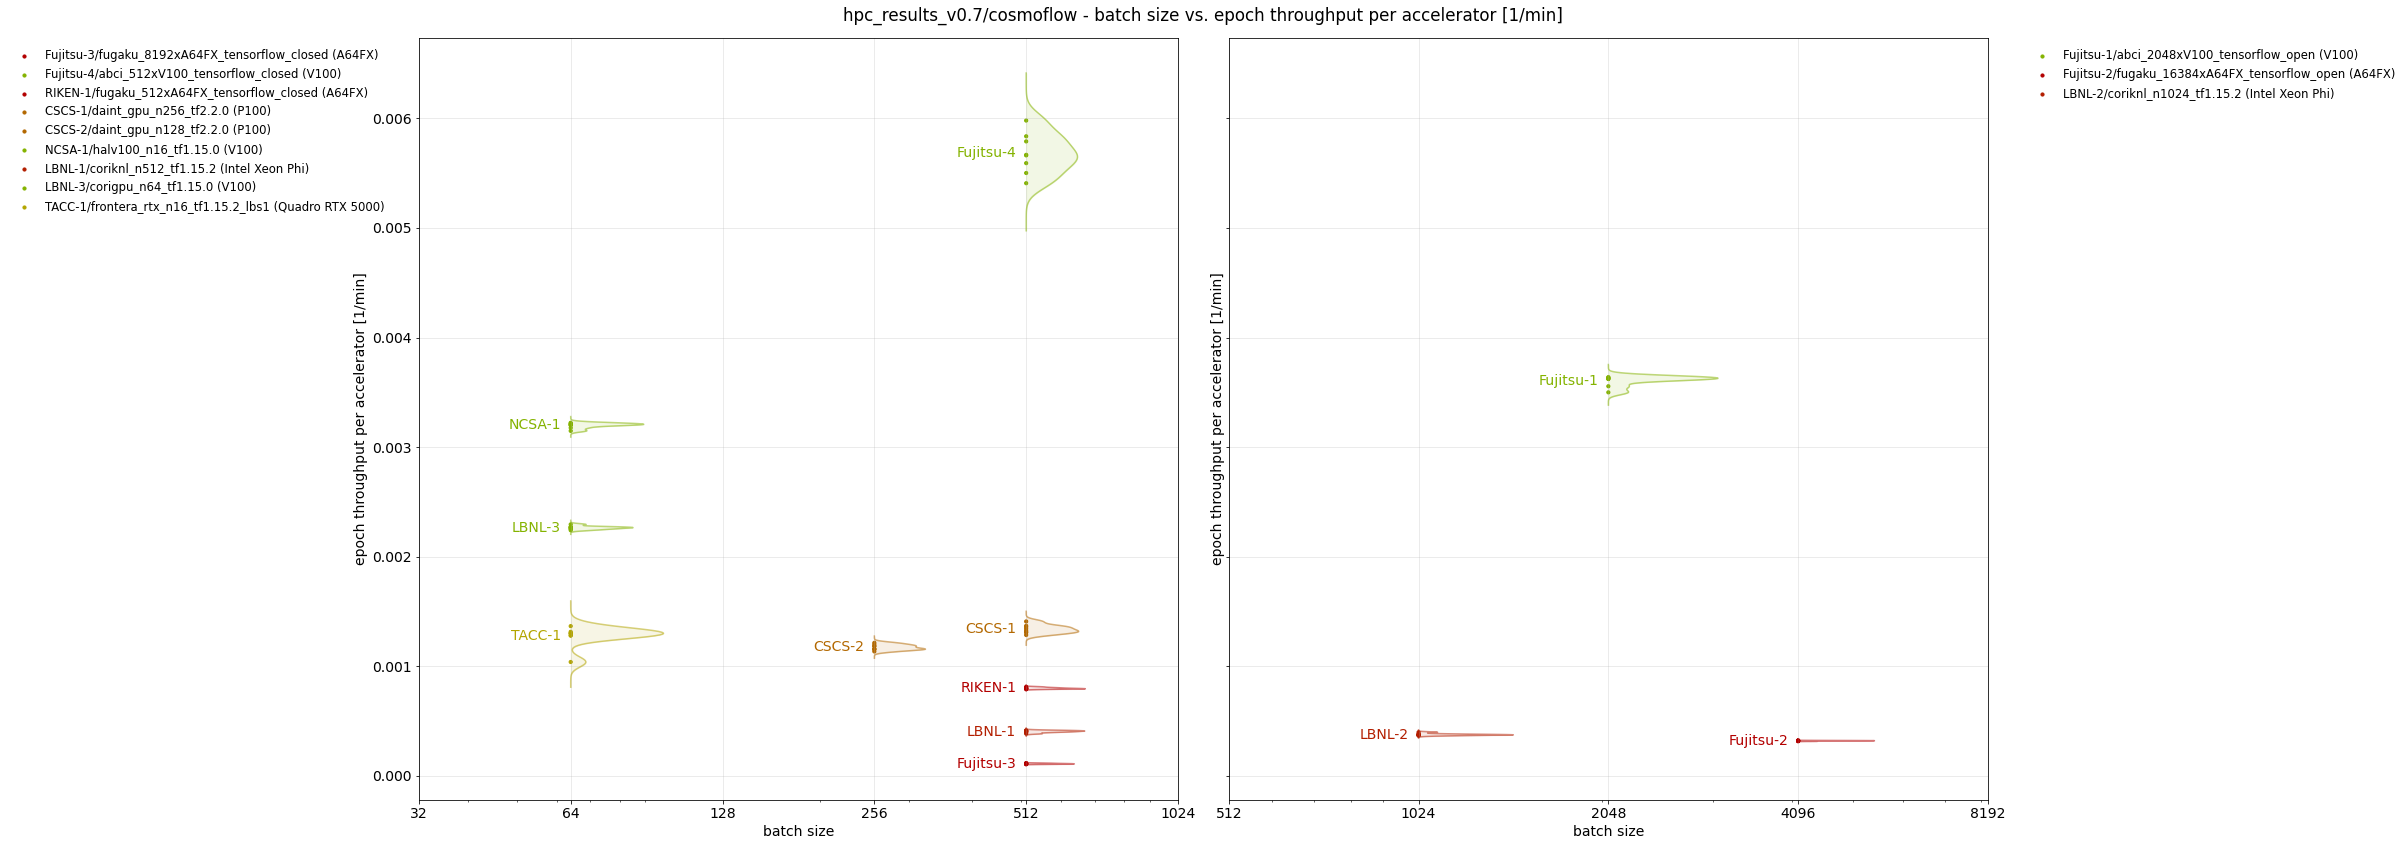

In [30]:
x_label = 'batch size'
x_key = 'global_batch_size'

# x_label = '# accelerators'
# x_key = lambda submission_stat: accelerator_number(submission_stat['system'])

y_label = 'epoch throughput per accelerator [1/min]'
y_key = lambda submission_stat: submission_stat['run']['run_stop_epoch']/(submission_stat['run']['run_time']*accelerator_number(submission_stat['system']))
y_transform = lambda t: t*60.

plot_all_submissions(x_key=x_key, x_label=x_label, y_key=y_key, y_label=y_label, y_transform=y_transform, sharey=True, axis_scale='semilogx', color_label=accelerator_short_label)

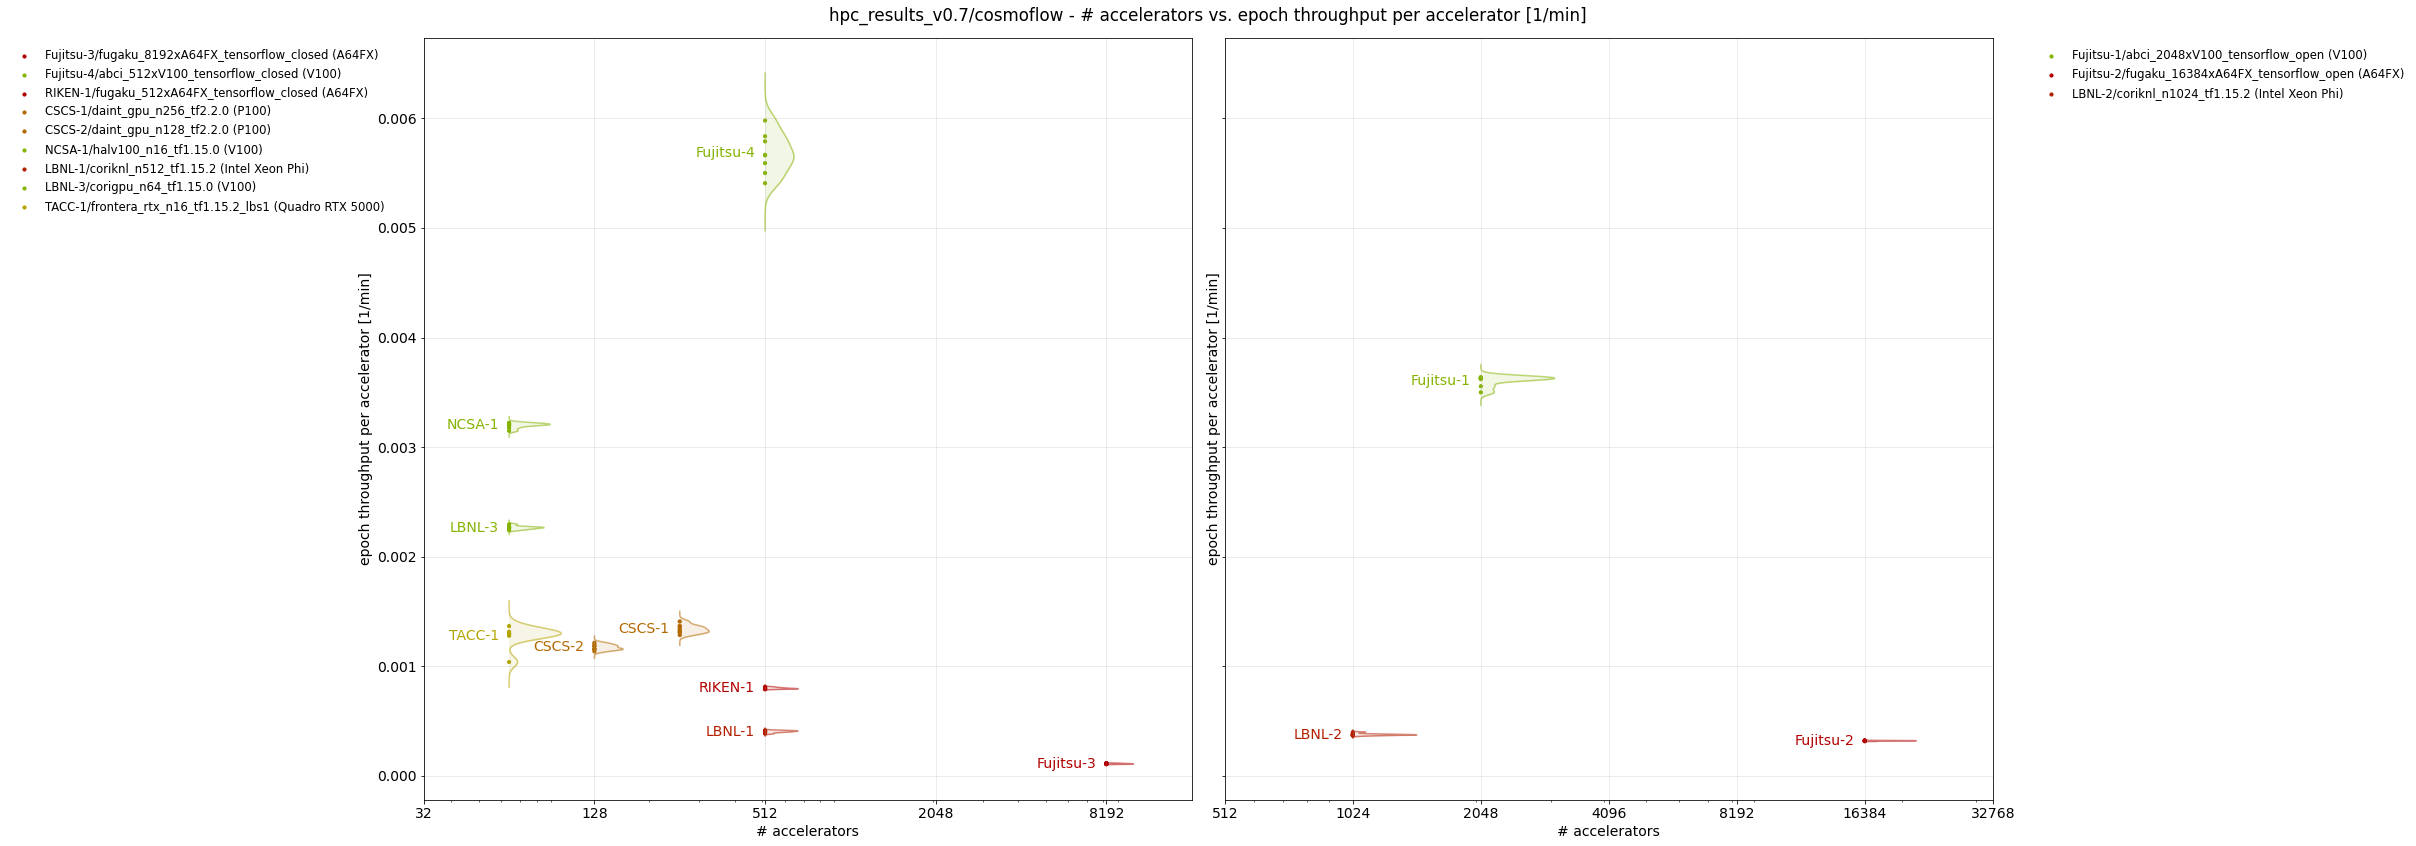

In [31]:
x_label = '# accelerators'
x_key = lambda submission_stat: accelerator_number(submission_stat['system'])

plot_all_submissions(x_key=x_key, x_label=x_label, y_key=y_key, y_label=y_label, y_transform=y_transform, sharey=True, axis_scale='semilogx', color_label=accelerator_short_label)

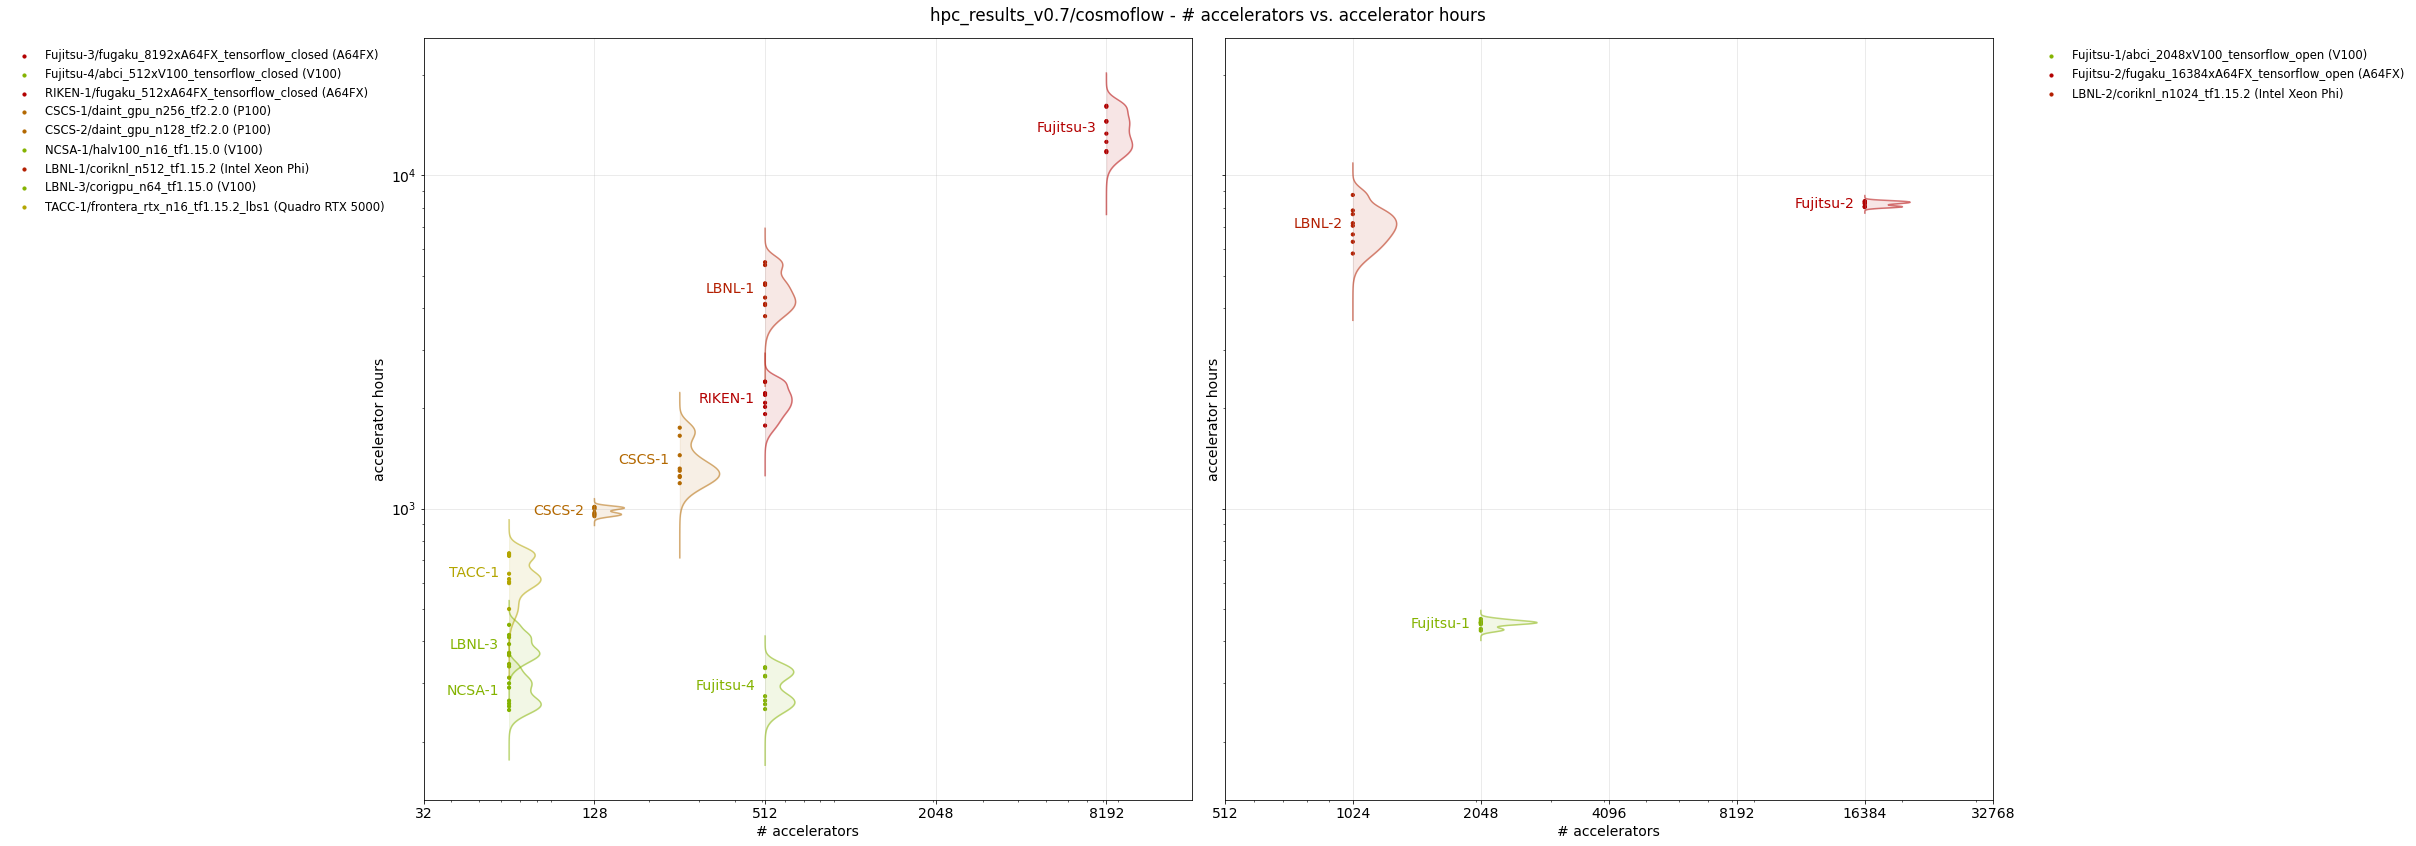

In [32]:
# x_label = 'batch size'
# x_key = 'global_batch_size'

x_label = '# accelerators'
x_key = lambda submission_stat: accelerator_number(submission_stat['system'])

y_label = 'accelerator hours'
y_key = get_accelerator_hours
y_transform = None

plot_all_submissions(x_key=x_key, x_label=x_label, y_key=y_key, y_label=y_label, y_transform=y_transform, sharey=True, axis_scale='loglog', color_label=accelerator_short_label)

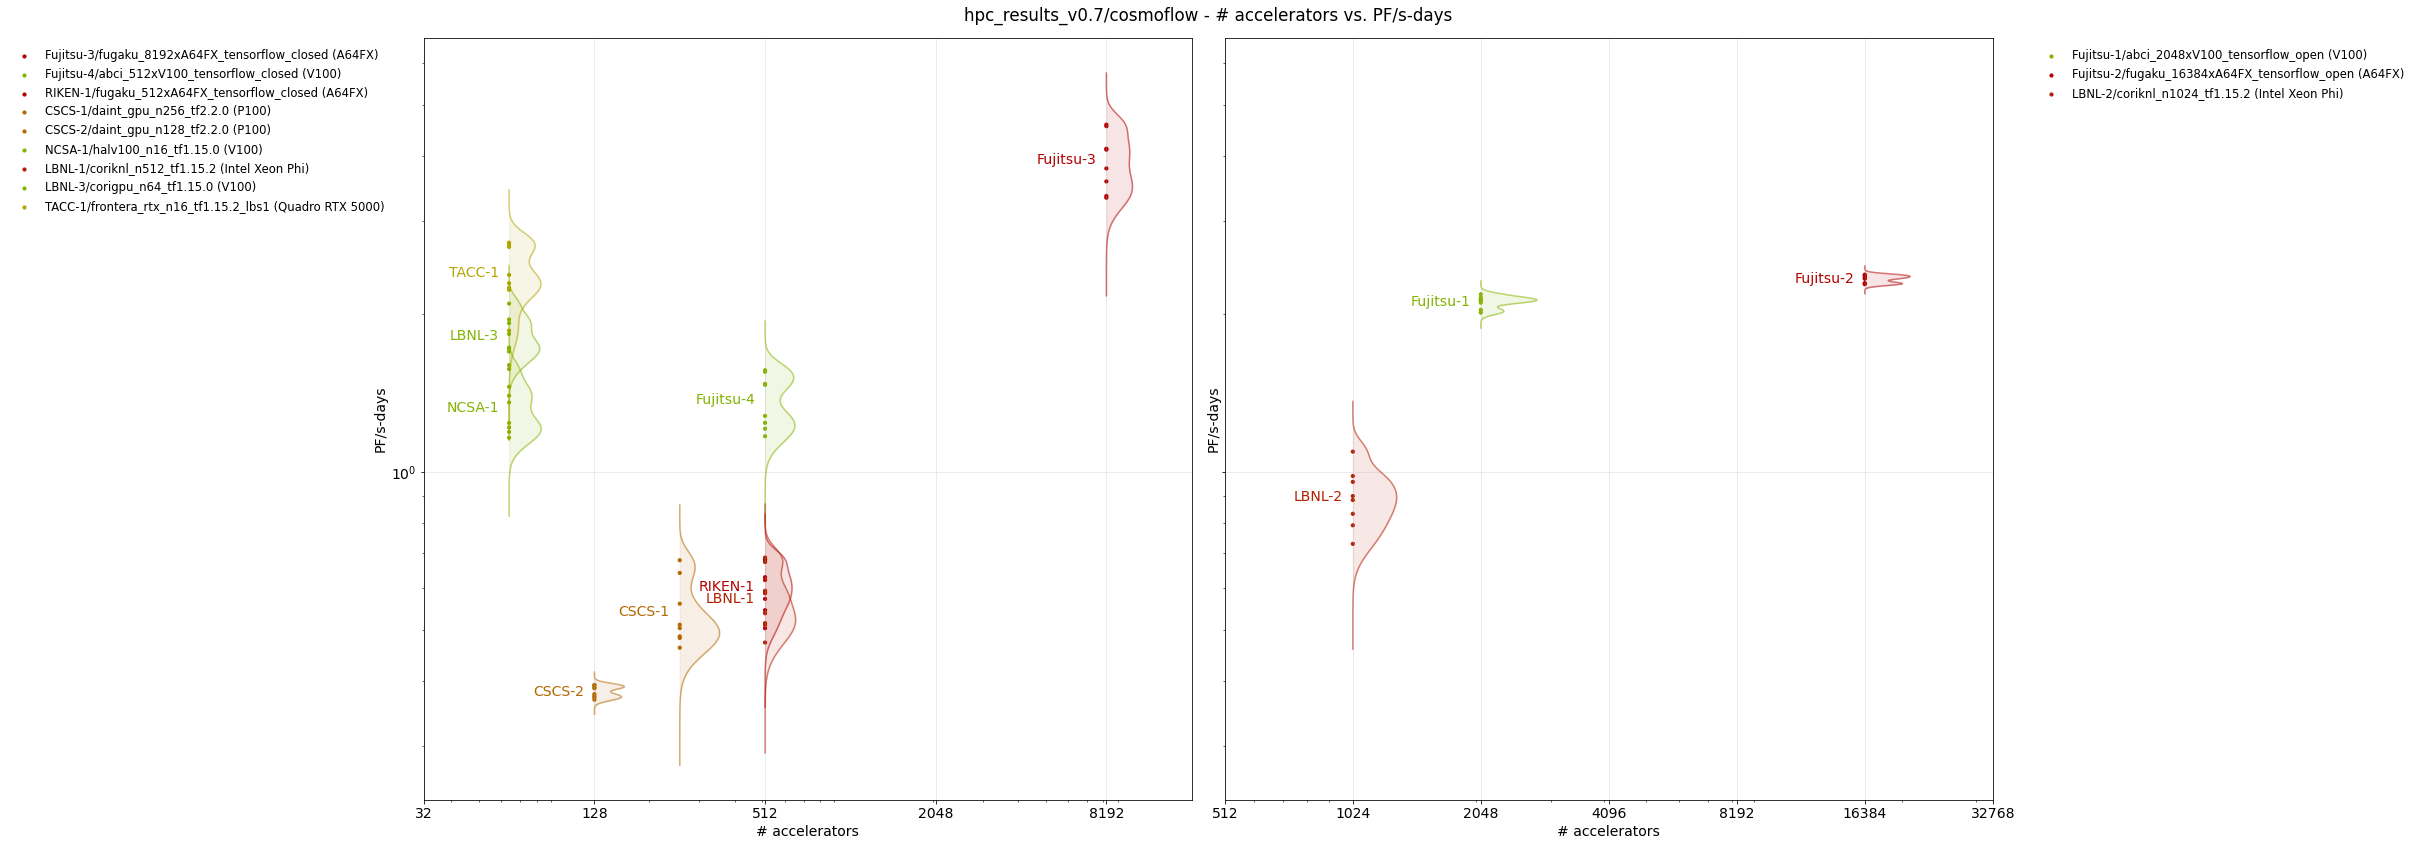

In [33]:
if benchmark.round == 'hpc_results_v0.7':
    # x_label = 'batch size'
    # x_key = 'global_batch_size'

    x_label = '# accelerators'
    x_key = lambda submission_stat: accelerator_number(submission_stat['system'])
    
    y_label = 'PF/s-days'
    y_key = get_pflopsdays
    y_transform = None

    plot_all_submissions(x_key=x_key, x_label=x_label, y_key=y_key, y_label=y_label, y_transform=y_transform, sharey=True, axis_scale='loglog', color_label=accelerator_short_label)

In [34]:
submissions_stats_df = pd.DataFrame.from_dict(submissions_stats, orient='index').sort_values(['division'])

In [35]:
def visualize_submissions_by_opt(submissions_stats_df_opt_vis, sort_keys=['global_batch_size']):
    if benchmark.round == 'training_results_v0.7':
        display(submissions_stats_df_opt_vis[(submissions_stats_df_opt_vis['division'] == 'closed') & (submissions_stats_df_opt_vis['opt_name'] == 'sgd')].drop(columns=[c for c in submissions_stats_df_opt_vis.columns if c.startswith('lars_')]).sort_values(sort_keys))
        display(submissions_stats_df_opt_vis[(submissions_stats_df_opt_vis['division'] == 'closed') & (submissions_stats_df_opt_vis['opt_name'] == 'lars')].drop(columns=[c for c in submissions_stats_df_opt_vis.columns if c.startswith('sgd_') or c == 'model_bn_span' or c == 'opt_learning_rate_warmup_epochs']).sort_values(sort_keys))
        display(submissions_stats_df_opt_vis[(submissions_stats_df_opt_vis['division'] == 'open')].sort_values(sort_keys))
    else:
        display(submissions_stats_df_opt_vis.sort_values(['division'] + sort_keys))

### Runtime statistics

In [36]:
submissions_stats_df_run_mean = submissions_stats_df['runs'].apply(lambda expt: pd.DataFrame.from_dict(expt).mean()).add_suffix('.mean')
submissions_stats_df_run_mean.index = submissions_stats_df.index
submissions_stats_df_run_std = submissions_stats_df['runs'].apply(lambda expt: pd.DataFrame.from_dict(expt).std()).add_suffix('.std')
submissions_stats_df_run_std.index = submissions_stats_df.index
submissions_stats_df_run = submissions_stats_df_run_mean.join(submissions_stats_df_run_std)
submissions_stats_df_run = submissions_stats_df_run[sorted(submissions_stats_df_run.columns)]
for c in submissions_stats_df_run.columns: # transform units from seconds to minutes
    if 'throughput' in c:
        submissions_stats_df_run[c] *= 60.
    elif 'time' in c:
        submissions_stats_df_run[c] /= 60.
submissions_stats_df_run.index = submissions_stats_df.index
submissions_stats_df_run

submissions_stats_df_run_vis = submissions_stats_df.drop(columns=['submission_short_label', 'runs', 'opt_opts', 'system']).join(submissions_stats_df_run).set_index('submission_label').sort_values(['division', 'global_batch_size'])
submissions_stats_df_run_vis
#visualize_submissions_by_opt(submissions_stats_df_run_vis)

,global_batch_size,opt_name,division,run_epoch_throughput.mean,run_epoch_throughput.std,run_stop_epoch.mean,run_stop_epoch.std,run_time.mean,run_time.std
submission_label,,,,,,,,,
NCSA-1/halv100_n16_tf1.15.0,64,SGD,closed,0.204608,0.001386,54.4,7.691265,265.762397,36.645978
LBNL-3/corigpu_n64_tf1.15.0,64,SGD,closed,0.145913,0.002337,53.9,6.723921,369.382803,45.212997
TACC-1/frontera_rtx_n16_tf1.15.2_lbs1,64,SGD,closed,0.082615,0.006114,49.1,6.999206,597.267820,91.651033
CSCS-2/daint_gpu_n128_tf2.2.0,256,SGD,closed,0.150696,0.003804,69.1,3.381321,458.855033,25.933043
Fujitsu-3/fugaku_8192xA64FX_tensorflow_closed,512,SGD,closed,0.905202,0.029026,93.0,15.040686,102.769162,16.563476
Fujitsu-4/abci_512xV100_tensorflow_closed,512,SGD,closed,2.893479,0.100769,99.7,14.772723,34.380798,4.348638
RIKEN-1/fugaku_512xA64FX_tensorflow_closed,512,SGD,closed,0.412567,0.011398,102.5,12.195172,248.877693,32.441916
CSCS-1/daint_gpu_n256_tf2.2.0,512,SGD,closed,0.341830,0.009975,110.0,17.044061,321.657435,47.800929
LBNL-1/coriknl_n512_tf1.15.2,512,SGD,closed,0.208204,0.005007,112.8,18.966637,542.178053,91.757486


### Optimizer convergence

In [37]:
submissions_stats_df_opt = pd.json_normalize(submissions_stats_df['opt_opts'])
submissions_stats_df_opt.index = submissions_stats_df.index
submissions_stats_df_opt = submissions_stats_df[['global_batch_size', 'opt_name']].join(submissions_stats_df_opt) #.add_prefix('opt.')

submissions_stats_df_opt_vis = submissions_stats_df.drop(columns=['submission_short_label', 'runs', 'global_batch_size', 'opt_name', 'opt_opts', 'system']).join(submissions_stats_df_run[['run_stop_epoch.mean', 'run_stop_epoch.std']]).join(submissions_stats_df_opt).set_index('submission_label')
visualize_submissions_by_opt(submissions_stats_df_opt_vis, sort_keys=['global_batch_size'])

,division,run_stop_epoch.mean,run_stop_epoch.std,global_batch_size,opt_name,opt_base_learning_rate,opt_learning_rate_warmup_epochs,opt_learning_rate_warmup_factor,opt_learning_rate_decay_boundary_epochs,opt_learning_rate_decay_factor
submission_label,,,,,,,,,,
NCSA-1/halv100_n16_tf1.15.0,closed,54.4,7.691265,64,SGD,0.001,4.0,1.000,"[32, 64]",0.25
LBNL-3/corigpu_n64_tf1.15.0,closed,53.9,6.723921,64,SGD,0.001,4.0,1.000,"[32, 64]",0.25
TACC-1/frontera_rtx_n16_tf1.15.2_lbs1,closed,49.1,6.999206,64,SGD,0.001,4.0,1.000,"[32, 64]",0.25
CSCS-2/daint_gpu_n128_tf2.2.0,closed,69.1,3.381321,256,SGD,0.004,4.0,4.000,"[32, 64]",0.25
Fujitsu-3/fugaku_8192xA64FX_tensorflow_closed,closed,93.0,15.040686,512,SGD,0.008,4.0,0.125,"[32, 64]",0.25
Fujitsu-4/abci_512xV100_tensorflow_closed,closed,99.7,14.772723,512,SGD,0.008,4.0,0.125,"[32, 64]",0.25
RIKEN-1/fugaku_512xA64FX_tensorflow_closed,closed,102.5,12.195172,512,SGD,0.008,4.0,0.125,"[32, 64]",0.25
CSCS-1/daint_gpu_n256_tf2.2.0,closed,110.0,17.044061,512,SGD,0.008,4.0,8.000,"[32, 64]",0.25
LBNL-1/coriknl_n512_tf1.15.2,closed,112.8,18.966637,512,SGD,0.008,4.0,8.000,"[32, 64]",0.25


### System performance (compute)

In [38]:
pd.set_option("display.max_columns", 0)
submissions_stats_df_system = pd.json_normalize(submissions_stats_df['system']).add_prefix('system.')
submissions_stats_df_system.index = submissions_stats_df.index

submissions_stats_df_system_run_vis = \
    submissions_stats_df_run[['run_epoch_throughput.mean','run_epoch_throughput.std']].join(submissions_stats_df_system)
submissions_stats_df_system_run_vis = \
    submissions_stats_df_run[['run_epoch_throughput.mean','run_epoch_throughput.std']].join(
        submissions_stats_df_system_run_vis.apply(lambda submissions_stat: submissions_stat['run_epoch_throughput.mean':'run_epoch_throughput.std']/
                                                                                                ( float(submissions_stat['system.number_of_nodes'])*
                                                                                                  float(submissions_stat['system.accelerators_per_node'] 
                                                                                                        if int(submissions_stat['system.accelerators_per_node']) > 0 
                                                                                                        else submissions_stat['system.host_processors_per_node']) ), axis=1).rename(columns=lambda s: '_per_accelerator.'.join(s.split('.'))))

submissions_stats_df_system_vis = submissions_stats_df.drop(columns=['submission_short_label', 'runs', 'opt_opts', 'system']).join(submissions_stats_df_system_run_vis).join(submissions_stats_df_system).set_index('submission_label')
# visualize_submissions_by_opt(submissions_stats_df_system_vis, sort_keys=['run_epoch_throughput_per_accelerator.mean'])
submissions_stats_df_system_vis.sort_values(['division', 'global_batch_size']) # 'run_epoch_throughput_per_accelerator.mean'])

,global_batch_size,opt_name,division,run_epoch_throughput.mean,run_epoch_throughput.std,run_epoch_throughput_per_accelerator.mean,run_epoch_throughput_per_accelerator.std,system.submitter,system.division,system.system_type,system.status,system.system_name,system.number_of_nodes,system.host_processors_per_node,system.host_processor_model_name,system.host_processor_core_count,system.host_processor_vcpu_count,system.host_processor_frequency,system.host_processor_caches,system.host_processor_interconnect,system.host_memory_capacity,system.host_storage_type,system.host_storage_capacity,system.host_networking,system.host_networking_topology,system.host_memory_configuration,system.accelerators_per_node,system.accelerator_model_name,system.accelerator_host_interconnect,system.accelerator_frequency,system.accelerator_on-chip_memories,system.accelerator_memory_configuration,system.accelerator_memory_capacity,system.accelerator_interconnect,system.accelerator_interconnect_topology,system.cooling,system.hw_notes,system.framework,system.other_software_stack,system.operating_system,system.sw_notes,system.other_software_stack.Cray MPICH,system.other_software_stack.Cray GNU,system.other_software_stack.Cray Python,system.other_software_stack.Horovod,system.other_software_stack.NCCL,system.other_software_stack.cuDNN,system.other_software_stack.CUDA,system.other_software_stack.CUDA Driver,system.other_software_stack.IBM WMLCE,system.other_software_stack.OpenMPI,system.other_software_stack.Cray-MPICH,system.other_software_stack.h5py,system.other_software_stack.horovod,system.other_software_stack.MPICH,system.host_processor_threads_per_core
submission_label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NCSA-1/halv100_n16_tf1.15.0,64,SGD,closed,0.204608,0.001386,0.003197,0.000022,NCSA,closed,NaN,onprem,hal_v100_n16_tf1.15.0,16,2,IBM POWER 9 model 2.2,40,160,2.3/3.8 GHz,32/512/10240 KB,X-Bus,256 GB DDR4,GPFS,0,infiniband EDR,,,4,NVIDIA Tesla V100,NVLink2,1.53 GHz,,,16 GB,NVLink2,,Air,,Tensorflow-v1.15.0,NaN,CentOS 7.7,,NaN,NaN,NaN,0.20.0,NaN,NaN,10.1.243,NaN,1.6.2,4.0.3,NaN,NaN,NaN,NaN,NaN
LBNL-3/corigpu_n64_tf1.15.0,64,SGD,closed,0.145913,0.002337,0.002280,0.000037,LBNL,closed,NaN,onprem,corigpu_n64_tf1.15.0,8,2,Intel Xeon Gold 6148,20,40,2.4 GHz,,,384 GB DDR4,on-node NVMe storage,930 GB,4 dual-port Mellanox MT27800 (ConnectX-5) EDR ...,,,8,NVIDIA V100,PCIe 3.0,1245 MHz,,,8 GB,NVLink,hybrid cube-mesh,,https://docs-dev.nersc.gov/cgpu/hardware/,Tensorflow 1.15.0,NaN,openSUSE 15.0,,NaN,NaN,NaN,NaN,2.4.8,7.6.5,10.0.130,NaN,NaN,NaN,NaN,2.9.0,0.19.0,3.3.1,NaN
TACC-1/frontera_rtx_n16_tf1.15.2_lbs1,64,SGD,closed,0.082615,0.006114,0.001291,0.000096,TACC,closed,Computing Center,available,Frontera-RTX,16,2,Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GH,8,16,2.1 GHz,"L1d cache: 32K, L1i cache: 32K, L2 cache: 256...",InfiniBand,128GB (2133 MT/s) DDR4,SSD,144GB /tmp partition on a 240GB SSD,FDR,Fat Tree,8x16GB,4,NVIDIA Quadro RTX 5000,,2100 MHz,16GB GDDR6 / card,,,,,Liquid Submerged : GRC ICE ICEraQ™ system,,tensorflow-gpu 1.15.2,gcc/9.1.0 cuda/10.0 cudnn/7.6.2 nccl/2.4.7 cma...,CentOS Linux release 7.8.2003,Local Batch Size 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
CSCS-2/daint_gpu_n128_tf2.2.0,256,SGD,closed,0.150696,0.003804,0.001177,0.000030,CSCS,closed,NaN,onprem,daint_gpu_n128_tf2.2.0,128,1,Intel(R) Xeon(R) E5-2690 v3 @ 2.60GHz,12,,,,,64 GB,,,Cray Aries routing and communications ASIC (9....,Dragonfly network topology,,1,NVIDIA P100-PCIE-16GB,PCIe 3 x16,1328 MHz,,,16 GB,,,,,TensorFlow 2.2.0,NaN,CLE7 UP02,,7.7.15,20.08,3.8.2.1,0.19.1,2.6.4,7.6.4,10.1.168,440.33.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fujitsu-3/fugaku_8192xA64FX_tensorflow_closed,512,SGD,closed,0.905202,0.029026,0.000110,0.000004,Fujitsu,closed,datacenter,available,fugaku_8192xA64FX_tensorflow_closed,8192,1,FUJITSU Processor A64FX,48 computing cores + 4 assistant cores (4 CMGs),,2200MHz,"L1: 64KiB I + 64KiB D per core, L2: 8MiB I+D x 4",,32GiB,,,TofuD interconnect [68GB/s x2 (in

In [39]:
submissions_stats_df_vis = submissions_stats_df.drop(columns=['submission_short_label', 'runs', 'global_batch_size', 'opt_name', 'opt_opts', 'system']).join(submissions_stats_df_run).join(submissions_stats_df_opt).join(submissions_stats_df_system).set_index('submission_label').sort_values(['division', 'global_batch_size'])
visualize_submissions_by_opt(submissions_stats_df_vis)
# the complete table

,division,run_epoch_throughput.mean,run_epoch_throughput.std,run_stop_epoch.mean,run_stop_epoch.std,run_time.mean,run_time.std,global_batch_size,opt_name,opt_base_learning_rate,opt_learning_rate_warmup_epochs,opt_learning_rate_warmup_factor,opt_learning_rate_decay_boundary_epochs,opt_learning_rate_decay_factor,system.submitter,system.division,system.system_type,system.status,system.system_name,system.number_of_nodes,system.host_processors_per_node,system.host_processor_model_name,system.host_processor_core_count,system.host_processor_vcpu_count,system.host_processor_frequency,system.host_processor_caches,system.host_processor_interconnect,system.host_memory_capacity,system.host_storage_type,system.host_storage_capacity,system.host_networking,system.host_networking_topology,system.host_memory_configuration,system.accelerators_per_node,system.accelerator_model_name,system.accelerator_host_interconnect,system.accelerator_frequency,system.accelerator_on-chip_memories,system.accelerator_memory_configuration,system.accelerator_memory_capacity,system.accelerator_interconnect,system.accelerator_interconnect_topology,system.cooling,system.hw_notes,system.framework,system.other_software_stack,system.operating_system,system.sw_notes,system.other_software_stack.Cray MPICH,system.other_software_stack.Cray GNU,system.other_software_stack.Cray Python,system.other_software_stack.Horovod,system.other_software_stack.NCCL,system.other_software_stack.cuDNN,system.other_software_stack.CUDA,system.other_software_stack.CUDA Driver,system.other_software_stack.IBM WMLCE,system.other_software_stack.OpenMPI,system.other_software_stack.Cray-MPICH,system.other_software_stack.h5py,system.other_software_stack.horovod,system.other_software_stack.MPICH,system.host_processor_threads_per_core
submission_label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NCSA-1/halv100_n16_tf1.15.0,closed,0.204608,0.001386,54.4,7.691265,265.762397,36.645978,64,SGD,0.001,4.0,1.000,"[32, 64]",0.25,NCSA,closed,NaN,onprem,hal_v100_n16_tf1.15.0,16,2,IBM POWER 9 model 2.2,40,160,2.3/3.8 GHz,32/512/10240 KB,X-Bus,256 GB DDR4,GPFS,0,infiniband EDR,,,4,NVIDIA Tesla V100,NVLink2,1.53 GHz,,,16 GB,NVLink2,,Air,,Tensorflow-v1.15.0,NaN,CentOS 7.7,,NaN,NaN,NaN,0.20.0,NaN,NaN,10.1.243,NaN,1.6.2,4.0.3,NaN,NaN,NaN,NaN,NaN
LBNL-3/corigpu_n64_tf1.15.0,closed,0.145913,0.002337,53.9,6.723921,369.382803,45.212997,64,SGD,0.001,4.0,1.000,"[32, 64]",0.25,LBNL,closed,NaN,onprem,corigpu_n64_tf1.15.0,8,2,Intel Xeon Gold 6148,20,40,2.4 GHz,,,384 GB DDR4,on-node NVMe storage,930 GB,4 dual-port Mellanox MT27800 (ConnectX-5) EDR ...,,,8,NVIDIA V100,PCIe 3.0,1245 MHz,,,8 GB,NVLink,hybrid cube-mesh,,https://docs-dev.nersc.gov/cgpu/hardware/,Tensorflow 1.15.0,NaN,openSUSE 15.0,,NaN,NaN,NaN,NaN,2.4.8,7.6.5,10.0.130,NaN,NaN,NaN,NaN,2.9.0,0.19.0,3.3.1,NaN
TACC-1/frontera_rtx_n16_tf1.15.2_lbs1,closed,0.082615,0.006114,49.1,6.999206,597.267820,91.651033,64,SGD,0.001,4.0,1.000,"[32, 64]",0.25,TACC,closed,Computing Center,available,Frontera-RTX,16,2,Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GH,8,16,2.1 GHz,"L1d cache: 32K, L1i cache: 32K, L2 cache: 256...",InfiniBand,128GB (2133 MT/s) DDR4,SSD,144GB /tmp partition on a 240GB SSD,FDR,Fat Tree,8x16GB,4,NVIDIA Quadro RTX 5000,,2100 MHz,16GB GDDR6 / card,,,,,Liquid Submerged : GRC ICE ICEraQ™ system,,tensorflow-gpu 1.15.2,gcc/9.1.0 cuda/10.0 cudnn/7.6.2 nccl/2.4.7 cma...,CentOS Linux release 7.8.2003,Local Batch Size 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
CSCS-2/daint_gpu_n128_tf2.2.0,closed,0.150696,0.003804,69.1,3.381321,458.855033,25.933043,256,SGD,0.004,4.0,4.000,"[32, 64]",0.25,CSCS,closed,NaN,onprem,daint_gpu_n128_tf2.2.0,128,1,Intel(R) Xeon(R) E5-2690 v3 @ 2.60GHz,12,,,,,64 GB,,,Cray Aries routing and communications ASIC (9....,Dragonfly network topology,,1,NVIDIA P100-PCIE-16GB,PCIe 3 x16,1328 MHz,,,16 GB,,,,,TensorFlow 2.2.0,NaN,CLE7 UP02,,7.7.15,20.08,3.8.2.1,0.19.1,2.6.4,7.6.4,10.1.168,440.33.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fujits